# Evaluate Trained Models
This notebook shows how to evaluate models trained to approximate arbitrary single unitary matrices.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

from qiskit.circuit.library.standard_gates import RZGate, RXGate, RYGate, SXGate, XGate
from qiskit.quantum_info import Operator, average_gate_fidelity, random_unitary
from qiskit.visualization import array_to_latex

from stable_baselines3 import PPO

from envs.HER_env_random_targets import HEREnvRandomTargets
from envs.PPO_env_random_targets import PPOEnvRandomTargets

In [6]:
def circuit_to_unitary(circuit):
    op = Operator(circuit)
    return op.to_matrix()

## Load trained models

In [4]:
# load trained model

rotation_gates = [RXGate(np.pi/128), RXGate(-np.pi/128),
                  RYGate(np.pi/128), RYGate(-np.pi/128),
                  RZGate(np.pi/128), RZGate(-np.pi/128)]

ibm_single_qubit_gate_set = [RZGate(np.pi/16), RZGate(-np.pi/16), SXGate(), XGate()]

GATES = rotation_gates
NUM_QUBITS = 1
TOLERANCE = 1e-2
MAX_STEPS = 320

env = PPOEnvRandomTargets(GATES, NUM_QUBITS, TOLERANCE, MAX_STEPS)
# env = HEREnvRandomTargets(GATES, NUM_QUBITS, TOLERANCE, MAX_STEPS)

# load a model trained with PPO or DQN / DQN+HER model
model = PPO.load('./trained_models/PPO_Rotation_Gates/best_model_100000000.zip', env=env)
#model = DQN.load('./models/best_model.zip', env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Create random unitary matrices as targets for the agent to approximate

Different random unitary matrices can be created by specifying a random seed in the env.reset() method.

In [23]:
# create a random target by setting a specific random seed
obs, info = env.reset(seed=0)
array_to_latex(circuit_to_unitary(env.target_unitary), prefix=r'\text{U} = ')

<IPython.core.display.Latex object>

In [33]:
# let the agent create a circuit to approximate the target unitary
obs, info = env.reset(seed=59)
print('Initial circuit:', circuit_to_unitary(env.target_unitary))
for i in range(320):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, terminated, dones, info = env.step(int(action))
    clear_output(wait=True)
    env.render(mode='human')
    time.sleep(0.1)
    if info['AGF'] >= 0.999:
        print(f'\nAGF 0.999 reached after {i+1} steps')
        break

   ┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
q: ┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├»
   └────────────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«   ┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
«q: ┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├»
«   └────────────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«   ┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
«q: ┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├»
«   └────────────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«   ┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
«q: ┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├┤ Rx(-π/128) ├»
«   └────────────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«   ┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
«q: ┤ Rx(-π/128

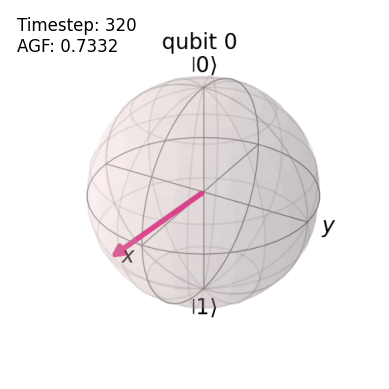

In [36]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Create a matplotlib figure and axis for displaying the Bloch sphere
fig, ax = plt.subplots()
ax.axis('off')

# Display the initial figure
obs, info = env.reset(seed=22)
bloch_image = env.render(mode='rgb_array') # the rgb_array mode returns an array that is a picture 
image = ax.imshow(bloch_image)
text = ax.text(0.02, 0.98, '', transform=ax.transAxes, ha='left', va='top', fontsize=12)
text.set_text(f'Timestep: {0}')
plt.pause(0.01)

# Run the agent for 100 steps
for i in range(320):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, terminated, dones, info = env.step(int(action))
    bloch_image = env.render(mode='rgb_array')

    # Update the image data, timestep, and display the figure
    image.set_data(bloch_image)
    text.set_text(f'Timestep: {i+1} \nAGF: {info["AGF"]:.4f}')
    clear_output(wait=True)
    display(fig)
    plt.pause(0.001)
    if info['AGF'] >= 0.999:
        print(f'AGF 0.999 reached after {i+1} steps')
        


AGF 0.99 reached after 141 steps


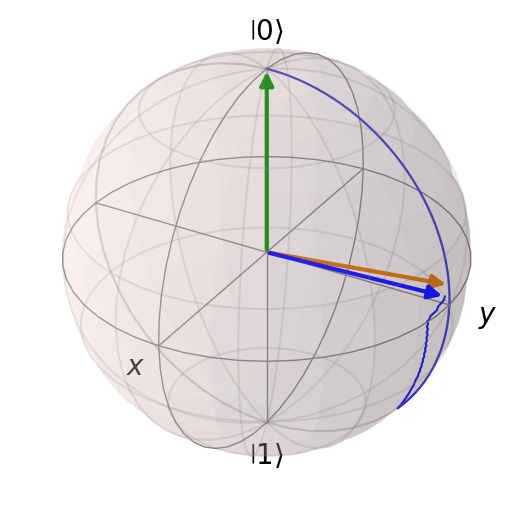

In [35]:
import matplotlib.pyplot as plt
from qutip import Bloch
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.visualization.state_visualization import _bloch_multivector_data
# Create an empty Bloch sphere
b = Bloch()
statevectors = []

# Display the initial figure
obs, info = env.reset(seed=59)
statevectors.append(env.render(mode='statevector')[0])

# Define the target state
qc = QuantumCircuit(1)
qc.append(Operator(env.target_unitary), [0])
target_state = _bloch_multivector_data(Statevector.from_instruction(qc))

# Run the agent for 100 steps
for i in range(320):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, dones, info = env.step(int(action))
    statevectors.append(env.render(mode='statevector')[0])
    if info['AGF'] >= 0.999:
        print(f'AGF 0.99 reached after {i+1} steps')
        break

x,y,z = zip(*statevectors)
b.add_points([x,y,z], meth='l',)
b.add_vectors([x[0],y[0],z[0]])
b.add_vectors(target_state)
b.add_vectors([x[-1],y[-1],z[-1]])

b.show()
#b.save('trajectory_on_bloch_sphere.png', dpin=300)

In [42]:
seeds = np.arange(500)
best_gate_fidelities = np.zeros(len(seeds))
steps_needed = np.zeros(len(seeds))
solved = np.zeros(len(seeds))

for s, seed in enumerate(seeds):
    # let the agent create a circuit to approximate the target unitary
    obs, info = env.reset(seed=int(seed))
    for i in range(128):
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, terminated, dones, info = env.step(int(action))
        gate_fidelity = info['AGF']
        if gate_fidelity >= 0.95:
            solved[s] = 1
        if gate_fidelity > best_gate_fidelities[s]:
            best_gate_fidelities[s] = gate_fidelity
            steps_needed[s] = i+1


print('percentage of solved unitaries: ', np.sum(solved)/len(seeds))

percentage of solved unitaries:  0.252


Text(0, 0.5, 'Number of different target unitaries')

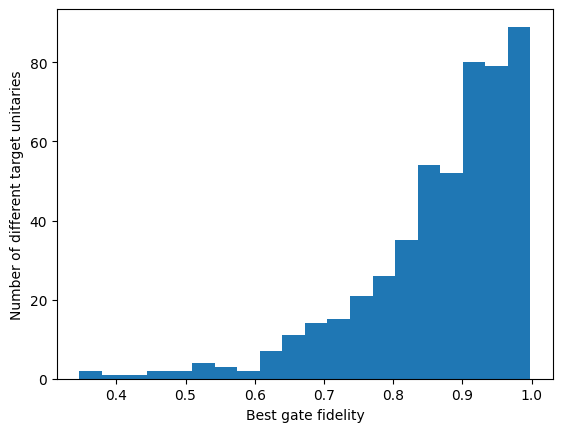

In [44]:
plt.hist(best_gate_fidelities, bins=20)
plt.xlabel('Best gate fidelity')
plt.ylabel('Number of different target unitaries')

Text(0, 0.5, 'Number of different target unitaries')

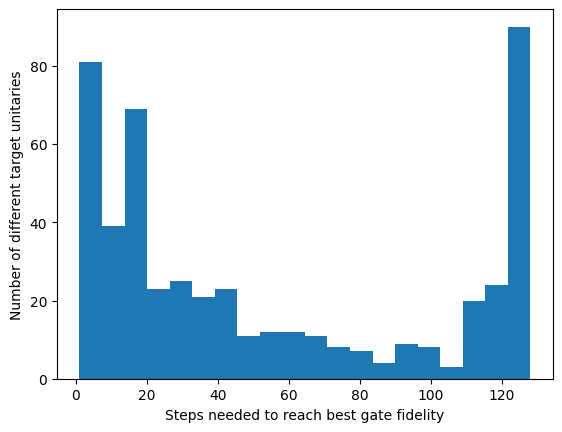

In [45]:
plt.hist(steps_needed, bins=20)
plt.xlabel('Steps needed to reach best gate fidelity')
plt.ylabel('Number of different target unitaries')